In [3]:
import numpy as np
import nibabel as nib
import glob
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler

This part of the code to get an initial understanding of the dataset.

1 Load sample images and visualize

2 Includes, dividing each image by its max to scale them to [0,1]

3 Converting mask from float to uint8

4 Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)

5 Visualize

#View a few images

In [7]:
scaler = MinMaxScaler()

TRAIN_DATASET_PATH = 'd:\BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print("Max:",test_image_flair.max())
print("Shape:",test_image_flair.shape)
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)


Max: 1854.603271484375
Shape: (240, 240, 155)


Now, we take the mask's values and we reencode them to the specifications that we need for the labels.

In [8]:
test_mask=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print("Original mask's values:", np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print("Updated values:",np.unique(test_mask)) 

Original mask's values: [0 1 2 4]
Updated values: [0 1 2 3]


Once we have reshaped and reencoded the data, we select a random subset of the data to visualize the images.

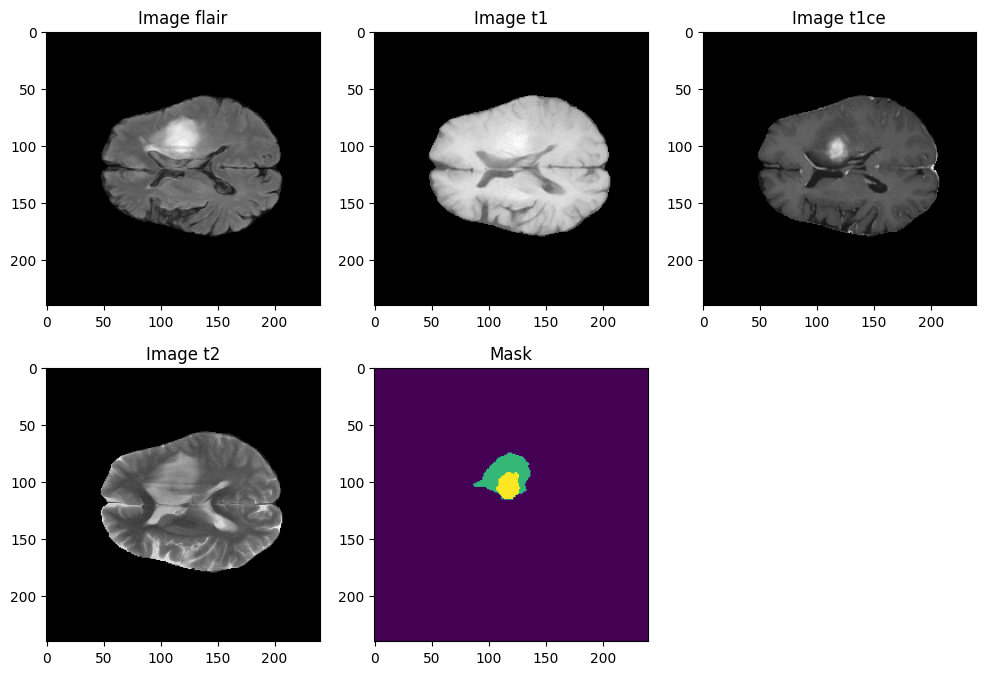

In [24]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Now that we have our test images loaded (channels), let's combine them into a single volume array for the training process. Note that T1 couldn't provide significant information for the training set, so we decide to exclude T1 from the volume array."

Includes:
#Combining all 4 images to 4 channels of a numpy array (Flair, T1CE, annd T2 have the most information).
#Combine t1ce, t2, and flair into single multichannel image

In [ ]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
